In [27]:
%%capture
!pip install pandas
!pip install spacy # for auto labeling 
!python -m spacy download en_core_web_sm

In [20]:
import pandas as pd

# Load the dataset
df = pd.read_csv('/mnt/f/datasets/data.csv')

# Display the total number of articles
print(f"Total articles available: {len(df)}")

# Sample 200 articles randomly
sampled_df = df.sample(n=200, random_state=42)

# Display the first few entries
sampled_df.head() 

Total articles available: 105375


,article_id,source_id,source_name,author,title,description,url,url_to_image,published_at,content,category,full_content
43325,63642,NaN,The Week Magazine,theweekonlineeditorsuk@futurenet.com (Keumars ...,Young teen wins top science prize for soap tha...,Memory of Ethiopian workers out in the sun ins...,https://theweek.com/science/young-teen-wins-to...,https://cdn.mos.cms.futurecdn.net/zAhQwHDgPJoS...,2023-10-27 09:38:42.000000,"A 14-year-old boy has been named ""America's to...",Ethiopia,NaN
19051,13370,NaN,Boing Boing,Rob Beschizza,"Vehicular homicide suspect who ""reeked of alco...","Ting Ye, 26, ""reeked of alcohol"" when she was ...",https://boingboing.net/2023/10/30/vehicular-ho...,https://i0.wp.com/boingboing.net/wp-content/up...,2023-10-30 12:09:58.000000,"Ting Ye, 26, ""reeked of alcohol"" when she was ...",United States,"Ting Ye, 26, ""reeked of alcohol"" when she was ..."
45314,69158,NaN,Eater,Martha Cheng,The Pastry Chefs Defining Restaurant Dessert R...,"Hannah Ziskin, Tavel Bristol-Jospeh, Kelly Nam...",https://www.eater.com/23919112/restaurant-past...,https://cdn.vox-cdn.com/thumbor/EdI5vEOW1_S11V...,2023-10-18 19:09:20.000000,Kelly Nam plates a dessert at New York City’s ...,Guyana,NaN
5671,97723,NaN,Boing Boing,Jennifer Sandlin,"Flula Borg hilarious deconstructs that weird ""...","Ok, one last Halloween post and I'll abandon t...",https://boingboing.net/2023/11/02/flula-borg-h...,https://i0.wp.com/boingboing.net/wp-content/up...,2023-11-02 09:02:40.000000,"Ok, one last Halloween post and I'll abandon t...",History,"Ok, one last Halloween post and I'll abandon t..."
78957,84216,NaN,Bangkok Post,Prasit Tangprasert,Korat zoo welcomes new member - sun bear,Nakhon Ratchasima Zoo has a new member - a one...,https://www.bangkokpost.com/thailand/general/2...,https://static.bangkokpost.com/media/content/2...,2023-10-05 03:50:00.000000,Nakhon Ratchasima Zoo has a new member - a one...,Myanmar,NaN


In [21]:
# NER - Named Entity Recognition 
print(sampled_df.columns)

Index(['article_id', 'source_id', 'source_name', 'author', 'title',
       'description', 'url', 'url_to_image', 'published_at', 'content',
       'category', 'full_content'],
      dtype='object')


In [23]:
# how many entries are available in full_content? 114  
sampled_df[['title', 'description', 'content', 'full_content']].notnull().sum()

title           200
description     200
content         200
full_content    114
dtype: int64

In [28]:
# use 114 full_content entries for now 
# use spacy for auto labeling 
import spacy

# Load English NER model
nlp = spacy.load("en_core_web_sm")

# Apply NER to each article
def extract_ner(text):
    doc = nlp(text)
    return [(ent.text, ent.start_char, ent.end_char, ent.label_) for ent in doc.ents]

# Filter non-null content
valid_articles = sampled_df[sampled_df['full_content'].notnull()]['full_content']

# Extract entities from each article
labeled_data = []
for text in valid_articles:
    entities = extract_ner(text)
    labeled_data.append((text, {"entities": [(start, end, label) for _, start, end, label in entities]}))


In [29]:
# labeled examples to verify structure 
for i in range(3):  # Show first 3 samples
    text, annotations = labeled_data[i]
    print("Text snippet:", text[:200])  # Print first 200 characters
    print("Entities:", annotations["entities"])
    print()


Text snippet: Ting Ye, 26, "reeked of alcohol" when she was pulled from the driver's seat of a 100MPH rollover crash that killed her passenger, Yabao Liu. While police in Washington state twiddled their thumbs, she
Entities: [(0, 7, 'PERSON'), (9, 11, 'DATE'), (81, 87, 'CARDINAL'), (130, 139, 'PERSON'), (157, 167, 'GPE'), (220, 245, 'ORG'), (249, 256, 'GPE'), (289, 294, 'GPE'), (296, 298, 'PERSON'), (351, 386, 'ORG'), (396, 399, 'ORG'), (538, 548, 'PERSON'), (554, 569, 'ORG'), (576, 591, 'ORG'), (601, 603, 'PERSON'), (608, 611, 'PERSON'), (621, 626, 'GPE'), (628, 630, 'PERSON'), (671, 676, 'PERSON'), (733, 738, 'GPE'), (743, 760, 'GPE'), (855, 868, 'PERSON'), (880, 890, 'PERSON'), (902, 913, 'PERSON'), (925, 934, 'PERSON')]

Text snippet: Ok, one last Halloween post and I'll abandon the topic until next year. As you're munching on your candy haul, watch this funnyvideocreated by German actor, comedian, and musicianFlula Borg. He begins
Entities: [(4, 7, 'CARDINAL'), (8, 22, 'DATE'), (6

In [7]:
%%capture 
!pip install spacy networkx langchain openai faiss-cpu sentence-transformers
!python -m spacy download en_core_web_sm
!pip install matplotlib
!pip install langchain_community
!pip install 

In [8]:
# Data prep and NER model
import spacy
import random
from spacy.tokens import DocBin
from spacy.util import minibatch, compounding
from spacy.training import Example

# Example corpus
corpus = [
    "Apple Inc. released a new iPhone in 2023.",
    "Tesla's CEO, Elon Musk, announced a new factory in China.",
]

# Training data (same as before)
train_data = [
    ("Apple Inc. released a new iPhone in 2023.", {"entities": [(0, 9, "ORG"), (27, 33, "PRODUCT")]}),
    ("Tesla's CEO, Elon Musk, announced a new factory in China.", {"entities": [(0, 5, "ORG"), (12, 20, "PERSON"), (47, 52, "GPE")]}),
]

def train_ner_model(train_data, iterations=30):
    nlp = spacy.blank("en")
    ner = nlp.add_pipe("ner")
    for _, annotations in train_data:
        for ent in annotations.get("entities"):
            ner.add_label(ent[2])

    other_pipes = [pipe for pipe in nlp.pipe_names if pipe != "ner"]
    with nlp.disable_pipes(*other_pipes):
        optimizer = nlp.begin_training()
        for itn in range(iterations):
            random.shuffle(train_data)
            losses = {}
            # Convert train_data to Example objects
            examples = []
            for text, annotations in train_data:
                doc = nlp.make_doc(text)
                example = Example.from_dict(doc, annotations)
                examples.append(example)
            
            # Batch examples
            batches = minibatch(examples, size=compounding(4., 32., 1.001))
            for batch in batches:
                nlp.update(batch, drop=0.5, losses=losses, sgd=optimizer)
            print(f"Iteration {itn}, Losses: {losses}")
    return nlp

# Train and save the model
nlp = train_ner_model(train_data)
nlp.to_disk("./domain_ner_model")

/home/max/py-final/lib/python3.12/site-packages/spacy/training/iob_utils.py:149: UserWarning: [W030] Some entities could not be aligned in the text "Apple Inc. released a new iPhone in 2023." with entities "[(0, 9, 'ORG'), (27, 33, 'PRODUCT')]". Use `spacy.training.offsets_to_biluo_tags(nlp.make_doc(text), entities)` to check the alignment. Misaligned entities ('-') will be ignored during training.
  warnings.warn(
/home/max/py-final/lib/python3.12/site-packages/spacy/training/iob_utils.py:149: UserWarning: [W030] Some entities could not be aligned in the text "Tesla's CEO, Elon Musk, announced a new factory in..." with entities "[(0, 5, 'ORG'), (12, 20, 'PERSON'), (47, 52, 'GPE'...". Use `spacy.training.offsets_to_biluo_tags(nlp.make_doc(text), entities)` to check the alignment. Misaligned entities ('-') will be ignored during training.
  warnings.warn(


Iteration 0, Losses: {'ner': np.float32(15.500002)}
Iteration 1, Losses: {'ner': np.float32(15.194761)}
Iteration 2, Losses: {'ner': np.float32(14.912625)}
Iteration 3, Losses: {'ner': np.float32(14.503237)}
Iteration 4, Losses: {'ner': np.float32(14.212038)}
Iteration 5, Losses: {'ner': np.float32(13.625389)}
Iteration 6, Losses: {'ner': np.float32(13.140616)}
Iteration 7, Losses: {'ner': np.float32(12.215896)}
Iteration 8, Losses: {'ner': np.float32(11.300032)}
Iteration 9, Losses: {'ner': np.float32(10.8897295)}
Iteration 10, Losses: {'ner': np.float32(9.57784)}
Iteration 11, Losses: {'ner': np.float32(8.584178)}
Iteration 12, Losses: {'ner': np.float32(7.89551)}
Iteration 13, Losses: {'ner': np.float32(7.1883497)}
Iteration 14, Losses: {'ner': np.float32(5.933282)}
Iteration 15, Losses: {'ner': np.float32(4.5180845)}
Iteration 16, Losses: {'ner': np.float32(4.0399733)}
Iteration 17, Losses: {'ner': np.float32(3.4984453)}
Iteration 18, Losses: {'ner': np.float32(3.275228)}
Iteration

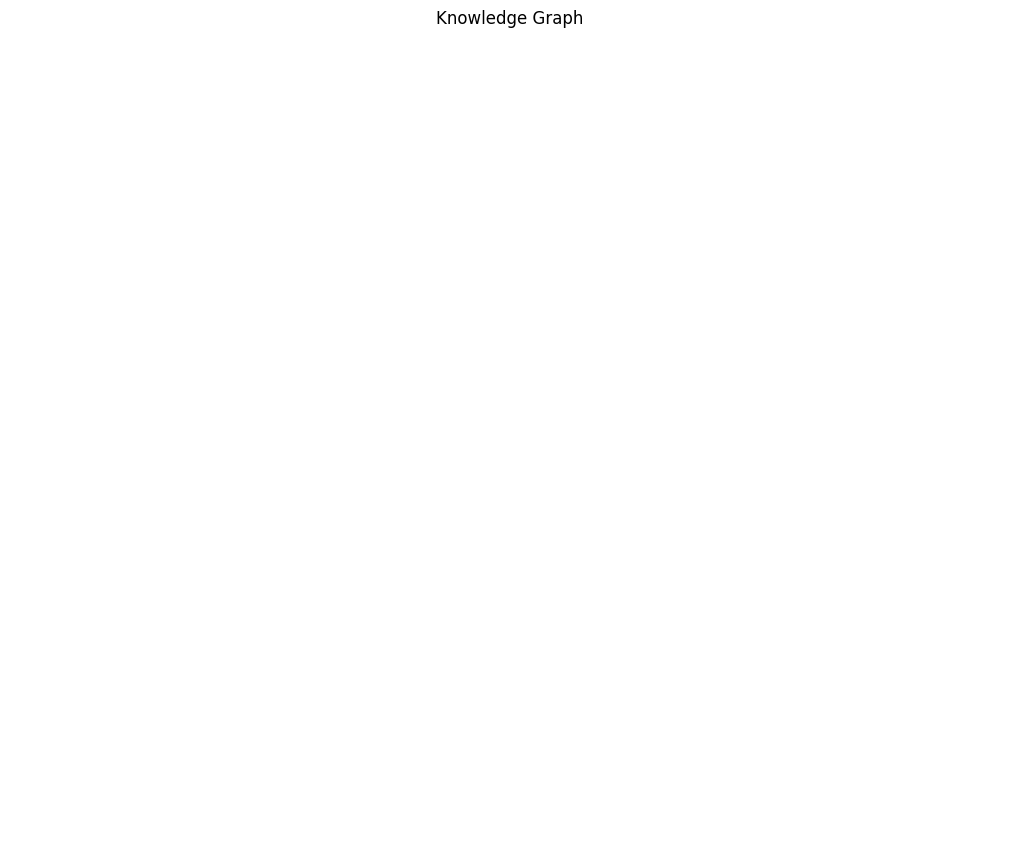

In [9]:
# Relationship extraction and KG 
import networkx as nx
import matplotlib.pyplot as plt

def extract_relationships(doc):
    relationships = []
    for sent in doc.sents:
        root = sent.root
        subject = None
        obj = None
        for child in root.children:
            if child.dep_ == "nsubj":
                subject = child
            if child.dep_ in ["dobj", "pobj"]:
                obj = child
        if subject and obj:
            relationships.append((subject, root, obj))
    return relationships

def process_document(text):
    doc = nlp(text)
    entities = [(ent.text, ent.label_) for ent in doc.ents]
    relationships = extract_relationships(doc)
    return entities, relationships

def build_knowledge_graph(documents):
    G = nx.DiGraph()
    for doc in documents:
        entities, relationships = process_document(doc)
        for entity, entity_type in entities:
            G.add_node(entity, type=entity_type)
        for subj, pred, obj in relationships:
            G.add_edge(subj.text, obj.text, relation=pred.text)
    return G

# Add sentencizer to the pipeline if not already present
if "sentencizer" not in nlp.pipe_names:
    nlp.add_pipe("sentencizer", before="ner")

knowledge_graph = build_knowledge_graph(corpus)

# Visualize
plt.figure(figsize=(10, 8))
pos = nx.spring_layout(knowledge_graph)
nx.draw(knowledge_graph, pos, with_labels=True, node_color='lightblue', node_size=500, font_size=10)
edge_labels = nx.get_edge_attributes(knowledge_graph, 'relation')
nx.draw_networkx_edge_labels(knowledge_graph, pos, edge_labels=edge_labels)
plt.title("Knowledge Graph")
plt.show()

In [10]:
# Base RAG system 
from langchain import OpenAI, PromptTemplate, LLMChain
from langchain.embeddings import OpenAIEmbeddings
from langchain.vectorstores import FAISS

embeddings = OpenAIEmbeddings(openai_api_key="your-api-key")
vectorstore = FAISS.from_texts(corpus, embeddings)
llm = OpenAI(temperature=0, openai_api_key="your-api-key")

rag_template = """Context: {context}

Question: {question}

Answer:"""
rag_prompt = PromptTemplate(template=rag_template, input_variables=["context", "question"])
rag_chain = LLMChain(llm=llm, prompt=rag_prompt)

def rag_query(question, k=3):
    relevant_docs = vectorstore.similarity_search(question, k=k)
    context = "\n".join([doc.page_content for doc in relevant_docs])
    return rag_chain.run(context=context, question=question)

question = "What did Apple release in 2023?"
print(rag_query(question))

ImportError: Could not import tiktoken python package. This is needed in order to for OpenAIEmbeddings. Please install it with `pip install tiktoken`.

In [ ]:
# kRAG System with Triple Integration

def get_relevant_triples(question, graph, k=5):
    entities = nlp(question).ents
    relevant_triples = []
    for entity in entities:
        if entity.text in graph:
            neighbors = list(graph.neighbors(entity.text))
            for neighbor in neighbors[:k]:
                edge_data = graph.get_edge_data(entity.text, neighbor)
                relevant_triples.append(f"{entity.text} {edge_data['relation']} {neighbor}")
    return relevant_triples

def krag_query(question, k=3):
    relevant_docs = vectorstore.similarity_search(question, k=k)
    context = "\n".join([doc.page_content for doc in relevant_docs])
    relevant_triples = get_relevant_triples(question, knowledge_graph)
    triples_context = "\n".join(relevant_triples)
    
    krag_template = """Context: {context}

    Relevant Knowledge Graph Triples:
    {triples_context}

    Question: {question}

    Answer:"""
    krag_prompt = PromptTemplate(template=krag_template, input_variables=["context", "triples_context", "question"])
    krag_chain = LLMChain(llm=llm, prompt=krag_prompt)
    
    return krag_chain.run(context=context, triples_context=triples_context, question=question)

question = "What did Apple release in 2023?"
print(krag_query(question))

In [ ]:
# Compare RAG and kRAG performance

test_questions = [
    "What did Apple release in 2023?",
    "Who is the CEO of Tesla?",
]

for question in test_questions:
    print(f"\nQuestion: {question}")
    print("Base RAG:", rag_query(question))
    print("kRAG:", krag_query(question))